In [1]:
import nflfastpy as npy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

In [2]:
font_paths = [
    "../../fonts/Poppins-Regular.ttf",
    "../../fonts/Poppins-Medium.ttf",
    "../../fonts/Poppins-SemiBold.ttf",
    "../../fonts/Poppins-Bold.ttf"
]

for path in font_paths:
    fm.fontManager.addfont(path)
    fm.FontProperties(fname=path)

In [3]:
df_2021 = npy.load_pbp_data(2021)
df_roster_2021 = npy.load_roster_data(2021)

In [4]:
for column in df_2021.columns:
    print(column)

play_id
game_id
old_game_id
home_team
away_team
season_type
week
posteam
posteam_type
defteam
side_of_field
yardline_100
game_date
quarter_seconds_remaining
half_seconds_remaining
game_seconds_remaining
game_half
quarter_end
drive
sp
qtr
down
goal_to_go
time
yrdln
ydstogo
ydsnet
desc
play_type
yards_gained
shotgun
no_huddle
qb_dropback
qb_kneel
qb_spike
qb_scramble
pass_length
pass_location
air_yards
yards_after_catch
run_location
run_gap
field_goal_result
kick_distance
extra_point_result
two_point_conv_result
home_timeouts_remaining
away_timeouts_remaining
timeout
timeout_team
td_team
td_player_name
td_player_id
posteam_timeouts_remaining
defteam_timeouts_remaining
total_home_score
total_away_score
posteam_score
defteam_score
score_differential
posteam_score_post
defteam_score_post
score_differential_post
no_score_prob
opp_fg_prob
opp_safety_prob
opp_td_prob
fg_prob
safety_prob
td_prob
extra_point_prob
two_point_conversion_prob
ep
epa
total_home_epa
total_away_epa
total_home_rush_epa


In [146]:
df_passing = df_2021[(df_2021["pass_attempt"] == 1) & (df_2021["two_point_attempt"] == 0)].copy()
df_passing = (
    df_passing.groupby(["passer_player_id", "week"], as_index=False)
    .agg(
        opponent=("defteam", "first"),
        completions=("complete_pass", "sum"),
        dropbacks=("pass_attempt", "sum"),
        yards=("passing_yards", "sum"),
        total_yards=("yards_gained", "sum"),
        tds=("pass_touchdown", "sum"),
        ints=("interception", "sum"),
        sacks=("sack", "sum")
    )
    .merge(df_roster_2021[["full_name", "gsis_id"]], left_on="passer_player_id", right_on="gsis_id")
)

In [147]:
# Sort by Passer and Week
df_passing_cum = df_passing.sort_values(["full_name", "week"]).copy().reset_index(drop=True)

# Get Cumulative Stats
df_passing_cum["completions"] = df_passing_cum.groupby("full_name")["completions"].cumsum()
df_passing_cum["dropbacks"] = df_passing_cum.groupby("full_name")["dropbacks"].cumsum()
df_passing_cum["yards"] = df_passing_cum.groupby("full_name")["yards"].cumsum()
df_passing_cum["total_yards"] = df_passing_cum.groupby("full_name")["total_yards"].cumsum()
df_passing_cum["tds"] = df_passing_cum.groupby("full_name")["tds"].cumsum()
df_passing_cum["ints"] = df_passing_cum.groupby("full_name")["ints"].cumsum()
df_passing_cum["sacks"] = df_passing_cum.groupby("full_name")["sacks"].cumsum()

In [148]:
# Calculate ANY/A
df_passing_cum["attempts"] = df_passing_cum["dropbacks"] - df_passing_cum["sacks"]
df_passing_cum["sack_yards_lost"] = df_passing_cum["yards"] - df_passing_cum["total_yards"]
df_passing_cum["any_a"] = (
    (df_passing_cum["yards"] + (20 * df_passing_cum["tds"]) - (45 * df_passing_cum["ints"]) - df_passing_cum["sack_yards_lost"]) / 
    df_passing_cum["dropbacks"]
)
df_passing_cum["y_a"] = df_passing_cum["yards"] / df_passing_cum["attempts"]

In [149]:
df_passing_cum

,passer_player_id,week,opponent,completions,dropbacks,yards,total_yards,tds,ints,sacks,full_name,gsis_id,attempts,sack_yards_lost,any_a,y_a
0,00-0035676,8,IND,0.0,1.0,0.0,0.0,0.0,0.0,0.0,A.J. Brown,00-0035676,1.0,0.0,0.000000,0.000000
1,00-0035676,16,SF,0.0,2.0,0.0,0.0,0.0,0.0,0.0,A.J. Brown,00-0035676,2.0,0.0,0.000000,0.000000
2,00-0023459,1,NO,15.0,29.0,133.0,122.0,0.0,2.0,1.0,Aaron Rodgers,00-0023459,28.0,11.0,1.103448,4.750000
3,00-0023459,2,DET,37.0,59.0,388.0,349.0,4.0,2.0,4.0,Aaron Rodgers,00-0023459,55.0,39.0,5.745763,7.054545
4,00-0023459,3,SF,60.0,93.0,649.0,602.0,6.0,2.0,5.0,Aaron Rodgers,00-0023459,88.0,47.0,6.795699,7.375000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631,00-0037013,13,PHI,141.0,268.0,1539.0,1328.0,6.0,11.0,25.0,Zach Wilson,00-0037013,243.0,211.0,3.555970,6.333333
632,00-0037013,14,NO,160.0,313.0,1741.0,1506.0,6.0,11.0,28.0,Zach Wilson,00-0037013,285.0,235.0,3.613419,6.108772
633,00-0037013,15,MIA,173.0,342.0,1911.0,1632.0,6.0,11.0,34.0,Zach Wilson,00-0037013,308.0,279.0,3.675439,6.204545
634,00-0037013,16,JAX,187.0,365.0,2013.0,1732.0,7.0,11.0,35.0,Zach Wilson,00-0037013,330.0,281.0,3.772603,6.100000


In [150]:
df_passing_cum[df_passing_cum["full_name"] == "Tom Brady"]

,passer_player_id,week,opponent,completions,dropbacks,yards,total_yards,tds,ints,sacks,full_name,gsis_id,attempts,sack_yards_lost,any_a,y_a
557,00-0019596,1,DAL,32.0,50.0,379.0,379.0,4.0,2.0,0.0,Tom Brady,00-0019596,50.0,0.0,7.380000,7.580000
558,00-0019596,2,ATL,56.0,89.0,655.0,638.0,9.0,2.0,3.0,Tom Brady,00-0019596,86.0,17.0,8.179775,7.616279
559,00-0019596,3,LA,97.0,147.0,1087.0,1049.0,10.0,2.0,6.0,Tom Brady,00-0019596,141.0,38.0,7.884354,7.709220
560,00-0019596,4,NE,119.0,191.0,1356.0,1310.0,10.0,2.0,7.0,Tom Brady,00-0019596,184.0,46.0,7.434555,7.369565
561,00-0019596,5,MIA,149.0,234.0,1767.0,1706.0,15.0,2.0,9.0,Tom Brady,00-0019596,225.0,61.0,8.188034,7.853333
562,00-0019596,6,PHI,183.0,276.0,2064.0,2003.0,17.0,3.0,9.0,Tom Brady,00-0019596,267.0,61.0,8.000000,7.730337
563,00-0019596,7,CHI,203.0,312.0,2275.0,2214.0,21.0,3.0,9.0,Tom Brady,00-0019596,303.0,61.0,8.009615,7.508251
564,00-0019596,8,NO,231.0,355.0,2650.0,2564.0,25.0,5.0,12.0,Tom Brady,00-0019596,343.0,86.0,7.997183,7.725948
565,00-0019596,10,WAS,254.0,389.0,2870.0,2784.0,27.0,7.0,12.0,Tom Brady,00-0019596,377.0,86.0,7.735219,7.612732
566,00-0019596,11,NYG,284.0,435.0,3177.0,3091.0,29.0,8.0,12.0,Tom Brady,00-0019596,423.0,86.0,7.611494,7.510638


In [138]:
# Get List of Passers with >100 completions
qb_list = (
    df_passing.groupby("full_name", as_index=False)
    .agg(
        {
            "completions": "sum",
            "dropbacks": "sum",
            "week": "max"
        }
    )
)

qb_list = (
    qb_list[qb_list["completions"] > 100]
    .merge(df_passing_cum[["full_name", "week", "any_a"]])
    .sort_values("any_a", ascending=False)
    .reset_index(drop=True)
)
qb_list

,full_name,completions,dropbacks,week,any_a
0,Aaron Rodgers,352.0,540.0,17,7.994444
1,Matthew Stafford,383.0,594.0,17,7.621212
2,Joe Burrow,366.0,571.0,17,7.514886
3,Jimmy Garoppolo,278.0,435.0,16,7.468966
4,Tom Brady,456.0,703.0,17,7.266003
5,Kirk Cousins,358.0,564.0,16,7.237589
6,Patrick Mahomes,409.0,641.0,17,7.102964
7,Kyler Murray,305.0,468.0,17,7.102564
8,Justin Herbert,409.0,636.0,17,7.099057
9,Dak Prescott,389.0,598.0,17,7.025084


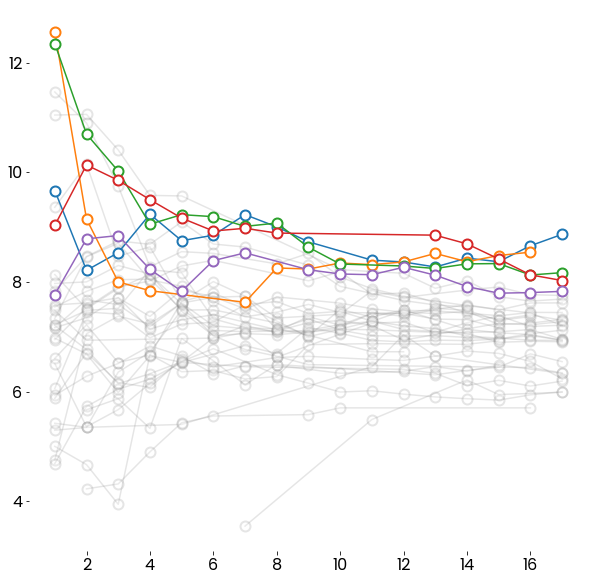

In [134]:
plt.rcParams["font.family"] = "Poppins"
plt.rcParams["font.size"] = 16

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, frame_on=False)

for qb in qb_list["full_name"][:5]:
    df_temp = df_passing_cum[df_passing_cum["full_name"] == qb].reset_index(drop=True).copy()
    ax.plot(df_temp["week"], df_temp["y_a"], marker="o", markersize=10, markeredgewidth=2, markerfacecolor="white", zorder=2)
    #ax.annotate(qb, xy=(df_temp.iloc[-1].week, df_temp.iloc[-1].any_a), xytext
    
for qb in qb_list["full_name"][5:]:
    df_temp = df_passing_cum[df_passing_cum["full_name"] == qb].copy()
    ax.plot(df_temp["week"], df_temp["y_a"], color="gray", alpha=0.2, marker="o", markersize=10, markeredgewidth=2, markerfacecolor="white", zorder=1)

plt.show()